In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.colors as mcolors
import pandas as pd


In [2]:
import torch
import torch.nn.utils

import sys
sys.path.append(os.path.abspath('../segment-anything-2'))

from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Fine Tuning

In [3]:
df = pd.DataFrame(
    {
        "ImageId": sorted(os.listdir('../data/processed/AneRBC-I/Anemic_individuals/image_patches')),
        "MaskId": sorted(os.listdir('../data/processed/AneRBC-I/Anemic_individuals/mask_patches'))
    }
)

df

,ImageId,MaskId
0,image_0_patch_0_0.png,mask_0_patch_0_0.png
1,image_0_patch_0_1.png,mask_0_patch_0_1.png
2,image_0_patch_0_2.png,mask_0_patch_0_2.png
3,image_0_patch_0_3.png,mask_0_patch_0_3.png
4,image_0_patch_0_4.png,mask_0_patch_0_4.png
...,...,...
31995,image_9_patch_7_3.png,mask_9_patch_7_3.png
31996,image_9_patch_7_4.png,mask_9_patch_7_4.png
31997,image_9_patch_7_5.png,mask_9_patch_7_5.png
31998,image_9_patch_7_6.png,mask_9_patch_7_6.png


In [4]:
# Path to the chest-ct-segmentation dataset folder
images_dir = '../data/processed/AneRBC-I/Anemic_individuals/image_patches'
masks_dir = '../data/processed/AneRBC-I/Anemic_individuals/mask_patches'

# Load the train.csv file
train_df = df.copy()

# Split the data into two halves: one for training and one for testing
train_df, test_df = train_test_split(train_df, test_size=0.96, random_state=42)

# Prepare the training data list
train_data = []
for index, row in train_df.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   train_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })

# Prepare the testing data list (if needed for inference or evaluation later)
test_data = []
for index, row in test_df.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   test_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })


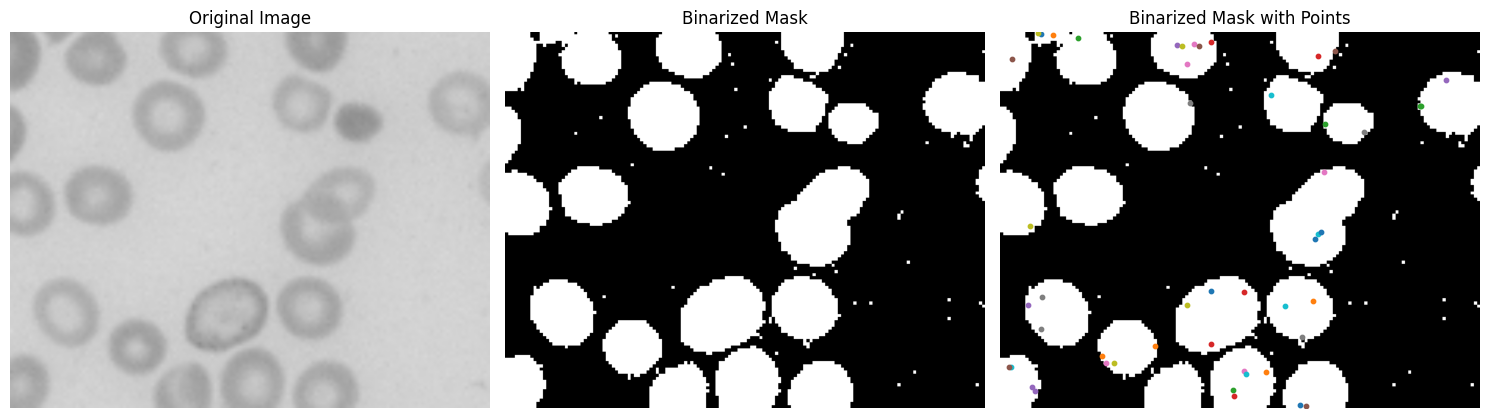

In [5]:
def read_batch(data, visualize_data=False):
   # Select a random entry
   ent = data[np.random.randint(len(data))]

   # Get full paths
   Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
   ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

   if Img is None or ann_map is None:
       print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
       return None, None, None, 0

   # Resize image and mask
   r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
   Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
   ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

   # Convert to binary mask (0 for background, 1 for masked region)
   binary_mask = np.where(ann_map == 255, 0, 1).astype(np.uint8)

   # Erode the binary mask to avoid boundary points
   eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

   # Get all coordinates inside the eroded mask (where the mask value is 1)
   coords = np.argwhere(eroded_mask > 0)

   # Select random points from the eroded mask
   num_points = 50  # Number of points to select

   # Randomly sample points from `coords` if there are enough points
   if len(coords) > num_points:
        points = coords[np.random.choice(len(coords), num_points, replace=False)]
   else:
        points = coords  # If fewer points exist, use all of them

   # Reformat points to (x, y) from (y, x)
   points = np.array([[p[1], p[0]] for p in points])

   if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=10, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

   binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
   binary_mask = binary_mask.transpose((2, 0, 1))
   points = np.expand_dims(points, axis=1)

   # Return the image, binarized mask, points, and number of masks
   return Img, binary_mask, points, num_points

# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

In [6]:
sam2_checkpoint = "../segment-anything-2/sam2_hiera_small.pt"
model_cfg = "C:/Users/saksh/OneDrive/Documents/Duke Academics/Spring 2025/Deep Learning/CV-Module-Project/segment-anything-2/sam2/configs/sam2/sam2_hiera_s.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)


In [7]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 1000 # @param

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2_test_1"

C:\Users\saksh\AppData\Local\Temp\ipykernel_11628\2944317104.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [8]:
torch.cuda.empty_cache()

In [ ]:
# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 2  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
   with torch.cuda.amp.autocast():
       image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)
       if image is None or mask is None or num_masks == 0:
           continue

       input_label = np.ones((num_masks, 1))
       if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
           continue

       if input_point.size == 0 or input_label.size == 0:
           continue

       predictor.set_image(image)
       mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
       if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
           continue

       sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
       )

       batched_mode = unnorm_coords.shape[0] > 1
       high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
       low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
           image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
           image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
           sparse_prompt_embeddings=sparse_embeddings,
           dense_prompt_embeddings=dense_embeddings,
           multimask_output=True,
           repeat_image=batched_mode,
           high_res_features=high_res_features,
       )
       prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

       gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
       prd_mask = torch.sigmoid(prd_masks[:, 0])
       seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

       inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
       iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
       score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
       loss = seg_loss + score_loss * 0.05

       # Apply gradient accumulation
       loss = loss / accumulation_steps
       scaler.scale(loss).backward()

       # Clip gradients
       torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

       if step % accumulation_steps == 0:
           scaler.step(optimizer)
           scaler.update()
           predictor.model.zero_grad()

       # Update scheduler
       scheduler.step()

       if step % 500 == 0:
           FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
           torch.save(predictor.model.state_dict(), os.path.join('../models', FINE_TUNED_MODEL))

       if step == 1:
           mean_iou = 0

       mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

       if step % 100 == 0:
           print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)


C:\Users\saksh\AppData\Local\Temp\ipykernel_11628\2589939876.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\saksh\OneDrive\Documents\Duke Academics\Spring 2025\Deep Learning\CV-Module-Project\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Step 100:	 Accuracy (IoU) =  0.4591916649151922
Step 200:	 Accuracy (IoU) =  0.7010331677392934
Step 300:	 Accuracy (IoU) =  0.7981535224140227
Step 400:	 Accuracy (IoU) =  0.842641176342562
Step 500:	 Accuracy (IoU) =  0.8393498306880744
Step 600:	 Accuracy (IoU) =  0.8430449887192208
Step 700:	 Accuracy (IoU) =  0.8538963901912426
Step 800:	 Accuracy (IoU) =  0.8578999061859365
Step 900:	 Accuracy (IoU) =  0.8644787318530425
Step 1000:	 Accuracy (IoU) =  0.8594224893846812


# Inference

In [65]:

def read_image(image_path, mask_path):  
    img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
    mask = cv2.imread(mask_path, 0)

    # Only resize if the image is larger than 1024 in any dimension
    if img.shape[0] > 1024 or img.shape[1] > 1024:
        r = min(1024 / img.shape[1], 1024 / img.shape[0])
        img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
        mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

In [68]:
def run_inference(image_path, mask_path):
    # Load the selected image and mask
    image, mask = read_image(image_path, mask_path)

    # Generate random points for the input
    num_samples = 50  # Number of points per segment to sample
    input_points = get_points(mask, num_samples)

    # Load the fine-tuned model
    FINE_TUNED_MODEL_WEIGHTS = "../models/fine_tuned_sam2_test_1_1000.torch"
    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

    # Build net and load weights
    predictor = SAM2ImagePredictor(sam2_model)
    predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

    # Perform inference and predict masks
    with torch.no_grad():
        image= image.copy()
        predictor.set_image(image)
        masks, scores, logits = predictor.predict(
            point_coords=input_points,
            point_labels=np.ones([input_points.shape[0], 1])
        )

    # Process the predicted masks and sort by scores
    np_masks = np.array(masks[:, 0])
    np_scores = scores[:, 0]
    sorted_masks = np_masks[np.argsort(np_scores)][::-1]

    # Initialize segmentation map and occupancy mask
    seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
    occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

    # Combine masks to create the final segmentation map
    for i in range(sorted_masks.shape[0]):
        mask = sorted_masks[i]
        if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
            continue

        mask_bool = mask.astype(bool)
        mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
        seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
        occupancy_mask[mask_bool] = True  # Update occupancy_mask

    return image, mask, seg_map


def visualize_results(image, ground_truth_mask, predicted_mask):
    """Visualizes the original image, ground truth mask, and predicted mask side by side."""
    
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display the original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Display the ground truth mask
    axes[1].imshow(ground_truth_mask, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')
    
    # Display the predicted segmentation mask
    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [49]:
import random

selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']


# Perform inference and visualize the results
image, mask, seg_map = run_inference(image_path, mask_path)

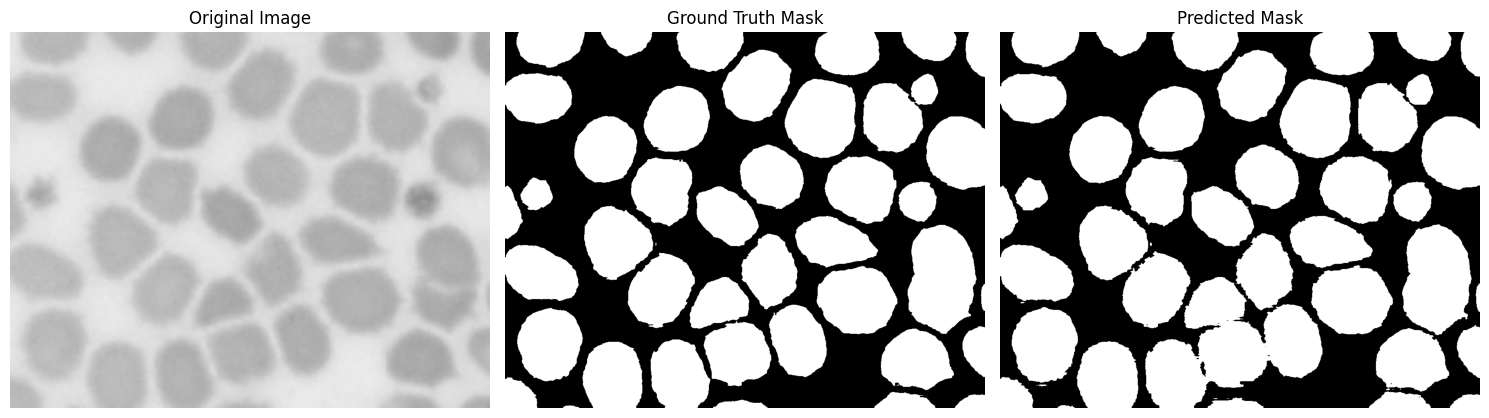

In [50]:
visualize_results(image, mask, seg_map)

In [51]:
# Function to compute Pixel Accuracy
def pixel_accuracy(y_true, y_pred):
    correct_pixels = np.sum(y_true == y_pred)
    total_pixels = np.prod(y_true.shape)
    return correct_pixels / total_pixels

# Function to compute IoU (Intersection over Union)
def iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union if union != 0 else 0.0

# Function to compute Dice Coefficient
def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0.0

# Function to compute Specificity
def specificity(y_true, y_pred):
    true_negatives = np.sum((y_true == 0) & (y_pred == 0))
    possible_negatives = np.sum(y_true == 0)
    return true_negatives / possible_negatives if possible_negatives != 0 else 0.0

# Function to compute Dice Loss (1 - Dice Coefficient)
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Example: Calculate metrics for a given test case
def calculate_metrics(mask, seg_map):
    # Convert mask and segmentation map to binary (0 or 1)
    mask_binary = (mask > 0).astype(np.uint8)
    seg_map_binary = (seg_map > 0).astype(np.uint8)

    # Calculate each metric
    pixel_acc = pixel_accuracy(mask_binary, seg_map_binary)
    iou_score = iou(mask_binary, seg_map_binary)
    dice_score = dice_coef(mask_binary, seg_map_binary)
    specificity_score = specificity(mask_binary, seg_map_binary)
    loss = dice_loss(mask_binary, seg_map_binary)

    return pixel_acc, iou_score, dice_score, specificity_score, loss


# Calculate metrics for this sample
pixel_acc, iou_score, dice_score, specificity_score, loss = calculate_metrics(mask, seg_map)
print(f"Pixel Accuracy: {pixel_acc:.4f}")
print(f"IoU: {iou_score:.4f}")
print(f"Dice Coefficient: {dice_score:.4f}")
print(f"Specificity: {specificity_score:.4f}")
print(f"Dice Loss: {loss:.4f}")


Pixel Accuracy: 0.9830
IoU: 0.9701
Dice Coefficient: 0.9848
Specificity: 0.9668
Dice Loss: 0.0152


In [18]:
mean_pixel_accuracy = []
mean_iou_acc = []
mean_dc = []
mean_speci = []
mean_dl = []

for test_img in tqdm(test_data[:100]):
    image_path = test_img['image']
    mask_path = test_img['annotation']

    image, mask, seg_map = run_inference(image_path, mask_path)
    pixel_acc, iou_score, dice_score, specificity_score, loss = calculate_metrics(mask, seg_map)

    mean_pixel_accuracy.append(pixel_acc)
    mean_iou_acc.append(iou_score)
    mean_dc.append(dice_score)
    mean_speci.append(specificity_score)
    mean_dl.append(loss)

 51%|█████     | 51/100 [28:05<26:59, 33.06s/it]


KeyboardInterrupt: 

In [19]:
print(f"Mean Pixel Accuracy for 100 patches: {np.mean(mean_pixel_accuracy):.4f}")
print(f"IoU for 100 patches: {np.mean(mean_iou_acc):.4f}")
print(f"Dice Coefficient for 100 patches: {np.mean(mean_dc):.4f}")
print(f"Specificity for 100 patches: {np.mean(mean_speci):.4f}")
print(f"Dice Loss for 100 patches: {np.mean(mean_dl):.4f}")

Mean Pixel Accuracy for 100 patches: 0.9886
IoU for 100 patches: 0.9664
Dice Coefficient for 100 patches: 0.9828
Specificity for 100 patches: 0.9876
Dice Loss for 100 patches: 0.0172


In [73]:
import numpy as np
import imageio
import os

# Function to get patch filenames for a given image ID
def get_patch_filenames(image_id, base_path='../data/processed/AneRBC-I/Anemic_individuals'):
    image_filenames = []
    mask_filenames = []
    for i in range(8):  # 8 rows of patches
        for j in range(8):  # 8 columns of patches
            image_patch_filename = os.path.join(base_path, f'image_patches/image_{image_id}_patch_{i}_{j}.png')
            mask_patch_filename = os.path.join(base_path, f'mask_patches/mask_{image_id}_patch_{i}_{j}.png')

            image_filenames.append(image_patch_filename)
            mask_filenames.append(mask_patch_filename)

    return image_filenames, mask_filenames


for test_img in test_data:
    results = []
    
    image_path = test_img['image']
    mask_path = test_img['annotation']
    image_id = int(image_path.split('_')[-4])  # Extract the image ID from filename
    if len(str(image_id)) == 1:
        image_id = f"00{image_id+1}"
    elif len(str(image_id)) == 2:
        image_id = f"0{image_id+1}"
    else:
        image_id = f"{image_id+1}"
    original_mask_path = "../data/raw/AneRBC-I/Anemic_individuals/Binary_segmented/" + f"{image_id}_a.png"
    original_img_path = "../data/raw/AneRBC-I/Anemic_individuals/Original_images/" + f"{image_id}_a.png"
    original_mask = imageio.imread(original_mask_path) 
    original_img = imageio.imread(original_img_path) 
    
    # Get all patch filenames for the image
    image_patch_filenames, mask_patch_filenames = get_patch_filenames(image_id)

    if len(image_patch_filenames) == 64:
        # Load patches into a list
        for img_patch_filename, mask_patch_filename in tqdm(zip(sorted(image_patch_filenames), sorted(mask_patch_filenames))):
            image, mask, seg_map = run_inference(img_patch_filename, mask_patch_filename)
            results.append(seg_map)
            
        break



C:\Users\saksh\AppData\Local\Temp\ipykernel_11628\3407719821.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_mask = imageio.imread(original_mask_path)
C:\Users\saksh\AppData\Local\Temp\ipykernel_11628\3407719821.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_img = imageio.imread(original_img_path)
64it [37:20, 35.00s/it]


In [87]:
def unpatchify(patches, full_image_shape, patch_size=(120, 153)):

    h, w = patch_size  # Each patch is (120, 153)
    H, W = full_image_shape  # Full image should be (960, 1224)

    # Number of patches along height and width
    num_patches_h = H // h  # 960 / 120 = 8
    num_patches_w = W // w  # 1224 / 153 = 8

    # Initialize full image
    full_image = np.zeros((H, W), dtype=patches.dtype)

    patch_idx = 0
    for i in range(num_patches_h):  # 8 rows
        for j in range(num_patches_w):  # 8 cols
            full_image[i*h:(i+1)*h, j*w:(j+1)*w] = patches[patch_idx]
            patch_idx += 1

    return full_image


full_seg_map = unpatchify(np.array(results), original_img.shape[:2])

In [90]:
# convert original_mask to grayscale
original_mask = cv2.cvtColor(original_mask, cv2.COLOR_BGR2GRAY)

# invert full_seg_map
full_seg_map = 1 - full_seg_map

In [91]:
# Calculate metrics for the full image segmentation
pixel_acc, iou_score, dice_score, specificity_score, loss = calculate_metrics(original_mask, full_seg_map)

print(f"Image ID: {image_id}")
print(f"Pixel Accuracy: {pixel_acc}")
print(f"IoU: {iou_score}")
print(f"Dice Score: {dice_score}")
print(f"Specificity: {specificity_score}")
print(f"Dice Loss: {loss}")

Image ID: 425
Pixel Accuracy: 0.6188453159041394
IoU: 0.6188453159041394
Dice Score: 0.7645515106655003
Specificity: 0.0
Dice Loss: 0.2354484893344997


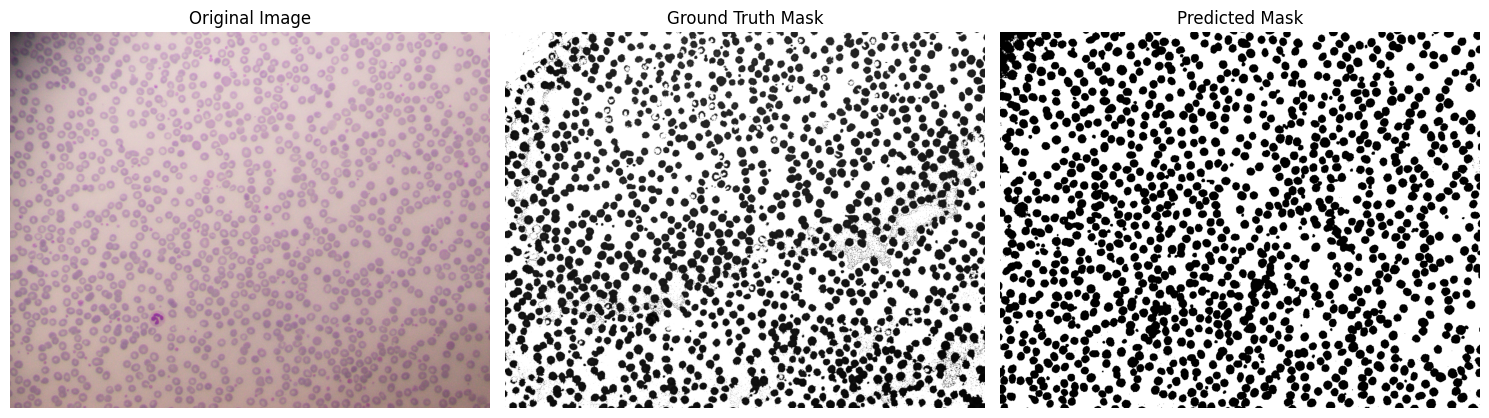

In [92]:
visualize_results(original_img, original_mask, full_seg_map)

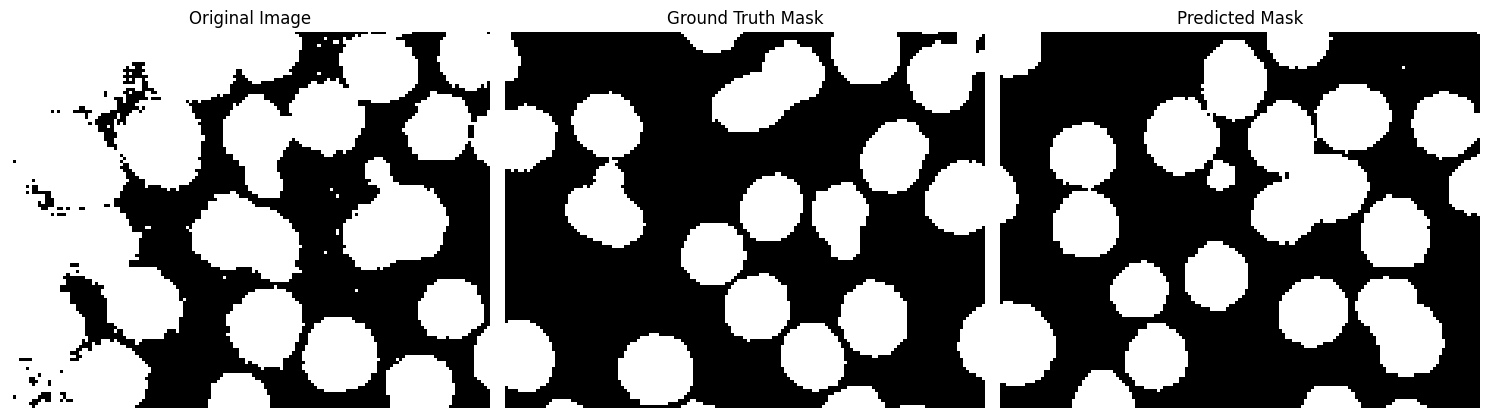

In [93]:
visualize_results(results[0], results[1], results[2])